# Non-ideal equations of state 
This example demonstrates a comparison between ideal and non-ideal equations of state (EoS) using Cantera and CoolProp. The following equations of state are used to evaluate thermodynamic properties in this example
1. Ideal-gas EoS from Cantera
2. Non-ideal Redlich-Kwong EoS from Cantera
3. Helmholtz energy EoS from CoolProp

#### Import required packages (Cantera and CoolProp)
[CoolProp](http://coolprop.org) [1] is an open-source package that contains a highly-accurate database for thermophysical properties. The thermodynamic properties are obtained using pure and pseudo-pure fluid equations of state implemented for 122 components.

>1. I.H. Bell, J.Wronski, S. Quoilin, V. Lemort, 'Pure and Pseudo-pure Fluid Thermophysical Property Evaluation and the Open-Source Thermophysical Property Library CoolProp,' Industrial & Engineering Chemistry Research 53 (2014), https://pubs.acs.org/doi/10.1021/ie4033999

In [1]:
# Import Cantera
import cantera as ct
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import time
print(f'Running Cantera version: {ct.__version__}')
from CoolProp.CoolProp import PropsSI

Running Cantera version: 2.6.0a2


### Helper functions
This example uses CO$_2$ as the only species. The function `get_thermo_Cantera` calculates thermodynamic properties based on the thermodynamic state ($T$, $p$) of the species using Cantera. Applicable gas-phases are `Ideal-gas` and `Redlich-Kwong`. The ideal-gas equation can be stated as
\begin{equation}
    pv = RT,
\end{equation}
where $p$, $v$ and $T$ represent thermodynamic pressure, molar volume, and the temperature of the gas-phase. $R$ is the universal gas constant.

The function `get_thermo_CoolProp` utilizes the CoolProp package to evaluate thermodynamic properties based on the gas-phase, thermodynamic state ($T$, $p$) for a given fluid. The standard-reference thermodynamic states are different for Cantera and CoolProp, it is necessary to convert these values in an appropriate scale before comparison. Therefore, both functions `get_thermo_Cantera` and `get_thermo_CoolProp` return the thermodynamic values relative to the reference state obtained at 1 Bar, 300 K.

To plot the comparison of thermodynamic properties among three EoS, the `plot` function is used. 

In [2]:
def get_thermo_Cantera(gas, T, p) :
    
    states = ct.SolutionArray(gas, len(p))
    X = 'CO2:1.0'
    states.TPX = T, p, X
    
    u = states.u
    h = states.h
    s = states.s
    cp = states.cp
    cv = states.cv
        
    # Get the relative enthalpy, entropy and int. energy with referance to the first point
    u = u - u[0]    
    s = s - s[0]    
    h = h - h[0]
        
    return  h, u, s, cp, cv

def get_thermo_CoolProp(T, p) :
    
    n = len(p)
    u = np.zeros(n)
    h = np.zeros(n)
    s = np.zeros(n)
    cp = np.zeros(n)
    cv = np.zeros(n)
    
    for i in range(n):
        
        #PropsSI("T","P",101325,"Q",0,"REFPROP::CO2")
        
        u[i] = PropsSI("U","P", p[i],"T", T,"HEOS::CO2")     # kJ/kg/K
        h[i] = PropsSI("H","P", p[i],"T", T,"HEOS::CO2")
        s[i] = PropsSI("S","P", p[i],"T", T,"HEOS::CO2")
        cp[i] = PropsSI("C","P", p[i],"T", T,"HEOS::CO2")
        cv[i] = PropsSI("O","P", p[i],"T", T,"HEOS::CO2")
        
    # Get the relative enthalpy, entropy and int. energy with referance to the first point
    u = u - u[1]    
    s = s - s[1]    
    h = h - h[1]    
        
    return  h, u, s, cp, cv

def plot(T, p, a_Ideal, a_RK, a_CoolProp, name) :
    
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['font.family'] = 'serif'

    #marker_size = 2
    line_width = 3 

    n = len(p)
    
    plt.figure()
    plt.plot(p/1e5, a_Ideal,'-',color='b', linewidth = line_width)
    plt.plot(p/1e5, a_RK,'-',color='r', linewidth = line_width)
    plt.plot(p/1e5, a_CoolProp,'-',color='k', linewidth = line_width)
    plt.xlabel('Pressure [Bar]')
    plt.ylabel(name)
    plt.legend(['Ideal EoS','RK EoS', 'CoolProp'], prop={'size': 14}, frameon=False)

## 1. EoS Comparison based on thermodynamic properties 

This is the main subroutine that compares and plots the thermodynamic values obtained using three equations of state. 

In [3]:
# Main function

# Input parameters
T = 300                               # Temperature is constant [unit:K]
p = 1e5*np.linspace(1, 100, 1000)     # Pressure is varied from 1 to 100 bar [unit:Pa]

# Read the ideal gas-phase
gasIdeal = ct.Solution('data/co2-thermo.yaml', 'CO2-Ideal', transport=None)
[hIdeal, uIdeal, sIdeal, cpIdeal, cvIdeal] = get_thermo_Cantera(gasIdeal, T, p) 

# Read the R-K gas-phase
gasRK = ct.Solution('data/co2-thermo.yaml', 'CO2-RK', transport=None)
[hRK, uRK, sRK, cpRK, cvRK] = get_thermo_Cantera(gasRK, T, p)

# Read the thermo data using CoolProp 
[hCoolProp, uCoolProp, sCoolProp, cpCoolProp, cvCoolProp] = get_thermo_CoolProp(T, p)

<IPython.core.display.Javascript object>


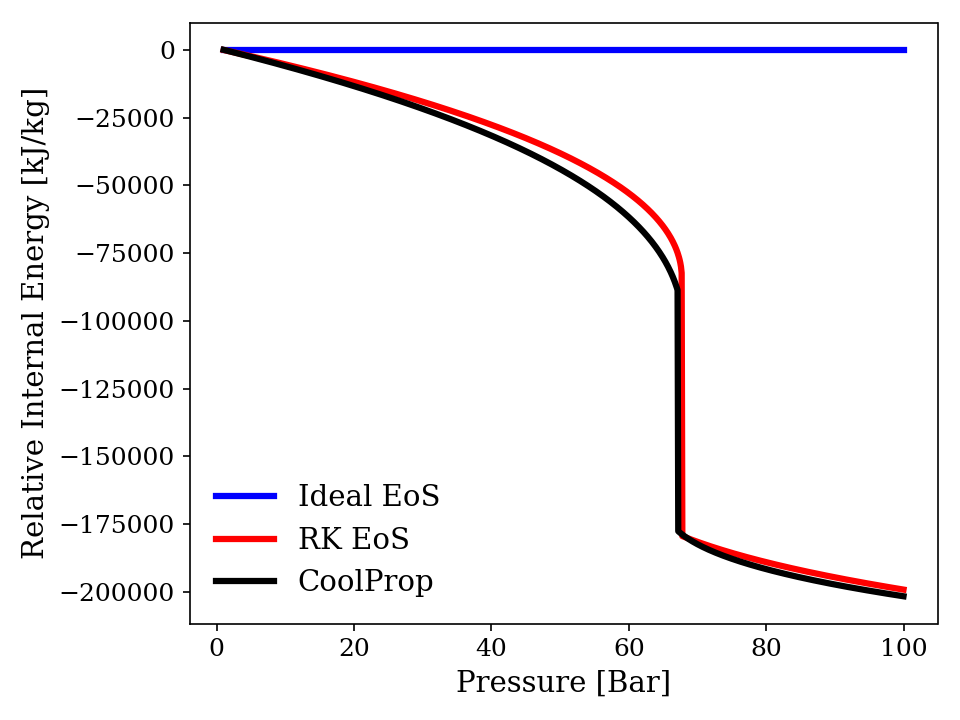

<IPython.core.display.Javascript object>


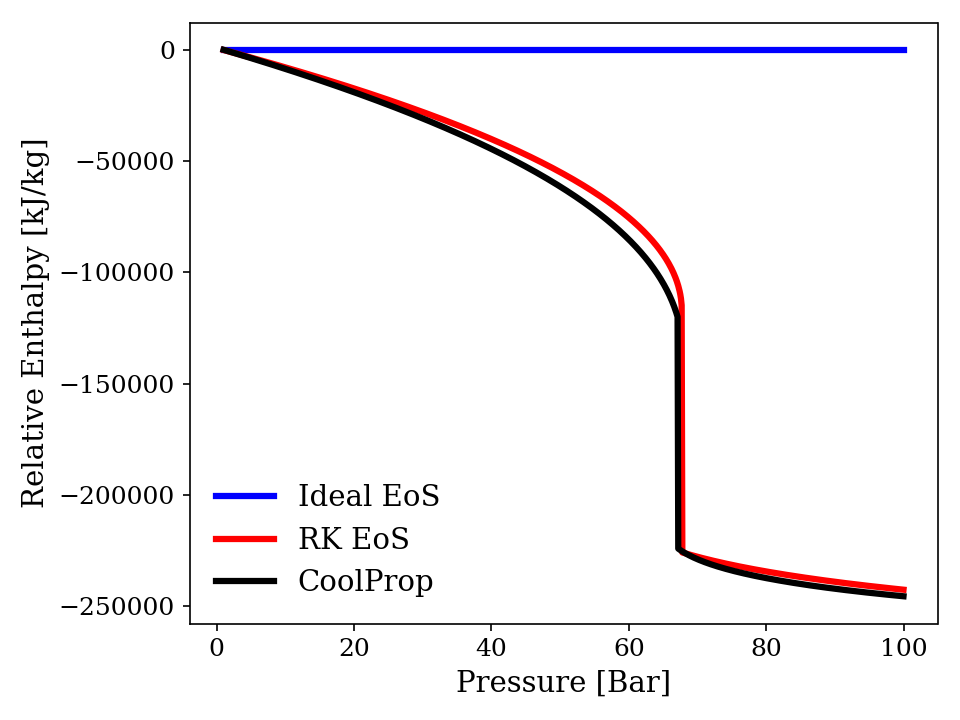

<IPython.core.display.Javascript object>


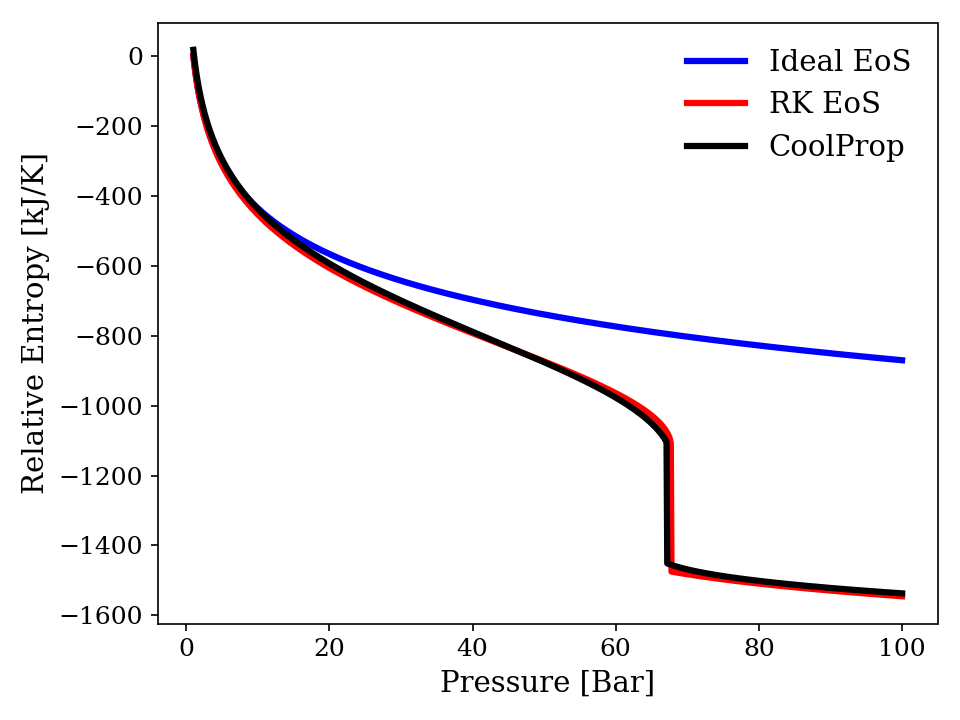

In [4]:
# Plot the result

# Internal energy
plot(T, p, uIdeal, uRK, uCoolProp, "Relative Internal Energy [kJ/kg]")
# Enthalpy
plot(T, p, hIdeal, hRK, hCoolProp, "Relative Enthalpy [kJ/kg]")
# Entropy
plot(T, p, sIdeal, sRK, sCoolProp, "Relative Entropy [kJ/K]")

The thermodynamic properties such as internal energy, enthalpy, and entropy are plotted against the operating pressure at a constant temperature $T = 300$ K. The three equations follow each other closely at low pressures ($P < 10$ Bar). However, the ideal gas EoS departs significantly from the observed behavior of gases near the critical regime ($P_{\rm {crit}} = 73.77$ Bar).

The ideal gas EoS does not consider inter-molecular interactions and the volume occupied by individual gas particles. At low temperatures and high pressures, inter-molecular forces become particularly significant due to a reduction in inter-molecular distances. Additionally, at high pressures, the volume of individual molecules becomes significant. Both of these factors contribute to the deviation from ideal behavior at high pressures. The cubic Redlich-Kwong EoS, on the other hand, predicts thermodynamic properties accurately near the critical regime. 

<IPython.core.display.Javascript object>


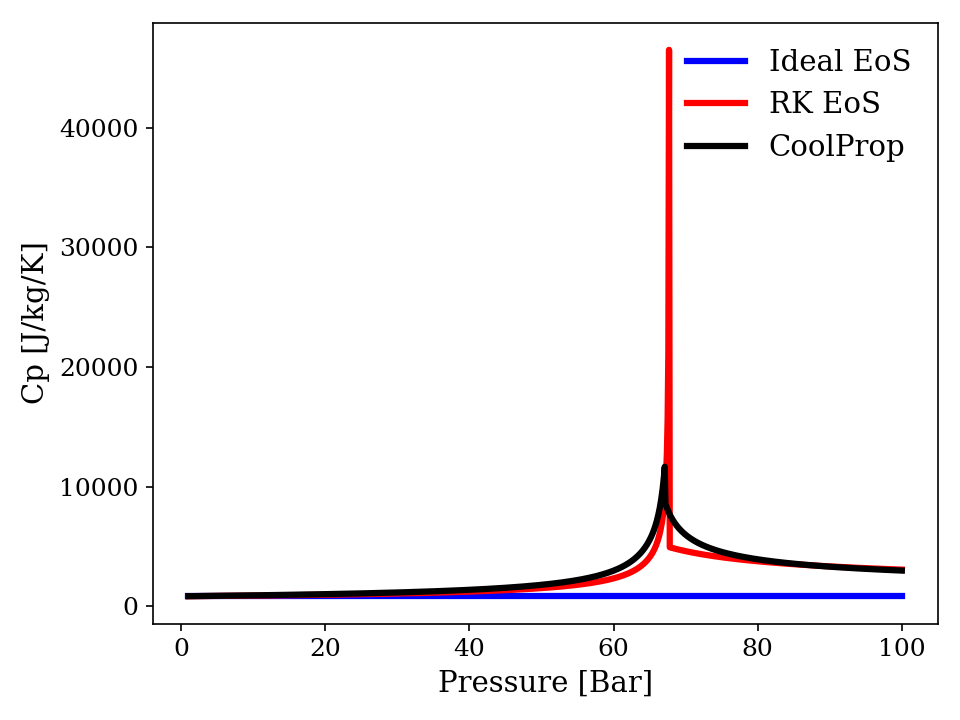

<IPython.core.display.Javascript object>


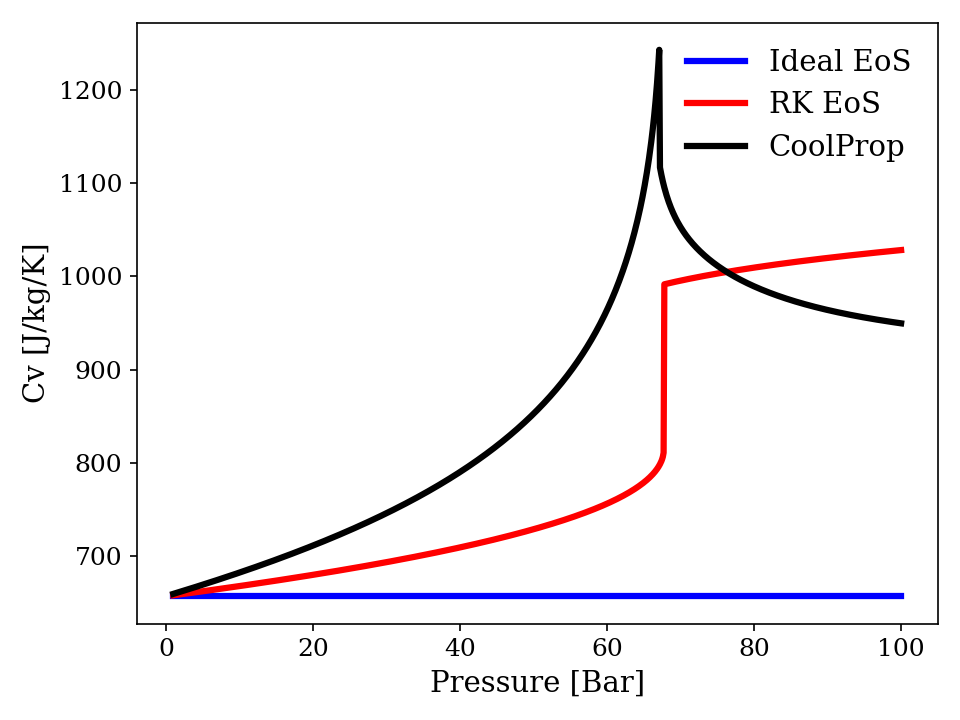

In [5]:
# Specific heat at constant pressure
plot(T, p, cpIdeal, cpRK, cpCoolProp, "Cp [J/kg/K]")
# Specific heat at constant volume
plot(T, p, cvIdeal, cvRK, cvCoolProp, "Cv [J/kg/K]")

In the case of Ideal gas EoS, the specific heats at constant pressure ($C_{\rm p}$) and constant volume ($C_{\rm v}$) are independent of the pressure. Hence, $C_{\rm p}$ and $C_{\rm v}$ for ideal EoS do not change as the pressure is varied from $1$ Bar to $100$ Bar in this study.

Specific heat at constant pressure ($C_{\rm p}$) for R-K EoS follow the trend closely with the Helmholtz EoS to the critical regime. Although the specific heat at constant pressure ($C_{\rm p}$) shows reasonable agreement with the Helmholtz EoS in sub-critical and supercritical regimes, it inaccurately predicts a very high value near the critical point. The heat capacity at constant pressure ($C_{\rm p}$) at the critical point is finite. The sudden rise in $C_{\rm p}$ value in the case of R-K EoS is just a numerical artifact and not a real singularity.

The specific heat at constant volume ($C_{\rm v}$), on the other hand, predicts smaller values in the subcritical and critical regime. However, it shows completely wrong values in the super-critical region, making it invalid at very high pressures. It is well known that the cubic equations typically fail to predict accurate constant-volume heat capacity in the transcritical region [2]. Certain cubic EoS models have been extended to resolve this discrepancy using crossover models. For further information, see the work of Span [2] and Saeed et al [3].

>2. R. Span, 'Multiparameter Equations of State - An Accurate Source of Thermodynamic Property Data', Springer Berlin Heidelberg (2000), http://dx.doi.org/10.1007/978-3-662-04092-8
>3. A. Saeed, S. Ghader,'Calculation of density, vapor pressure and heat capacity near the critical point by incorporating cubic SRK EoS and crossover translation', Fluid Phase Equilibria (2019) 493, https://doi.org/10.1016/j.fluid.2019.03.027

## 2. Temperature-Density plots

Following function plots the $T-\rho$ diagram over a wide pressure and temperature range. The temperature is varied from 250 K to 400 K. The pressure is changed from 1 Bar to 600 Bar.

<IPython.core.display.Javascript object>


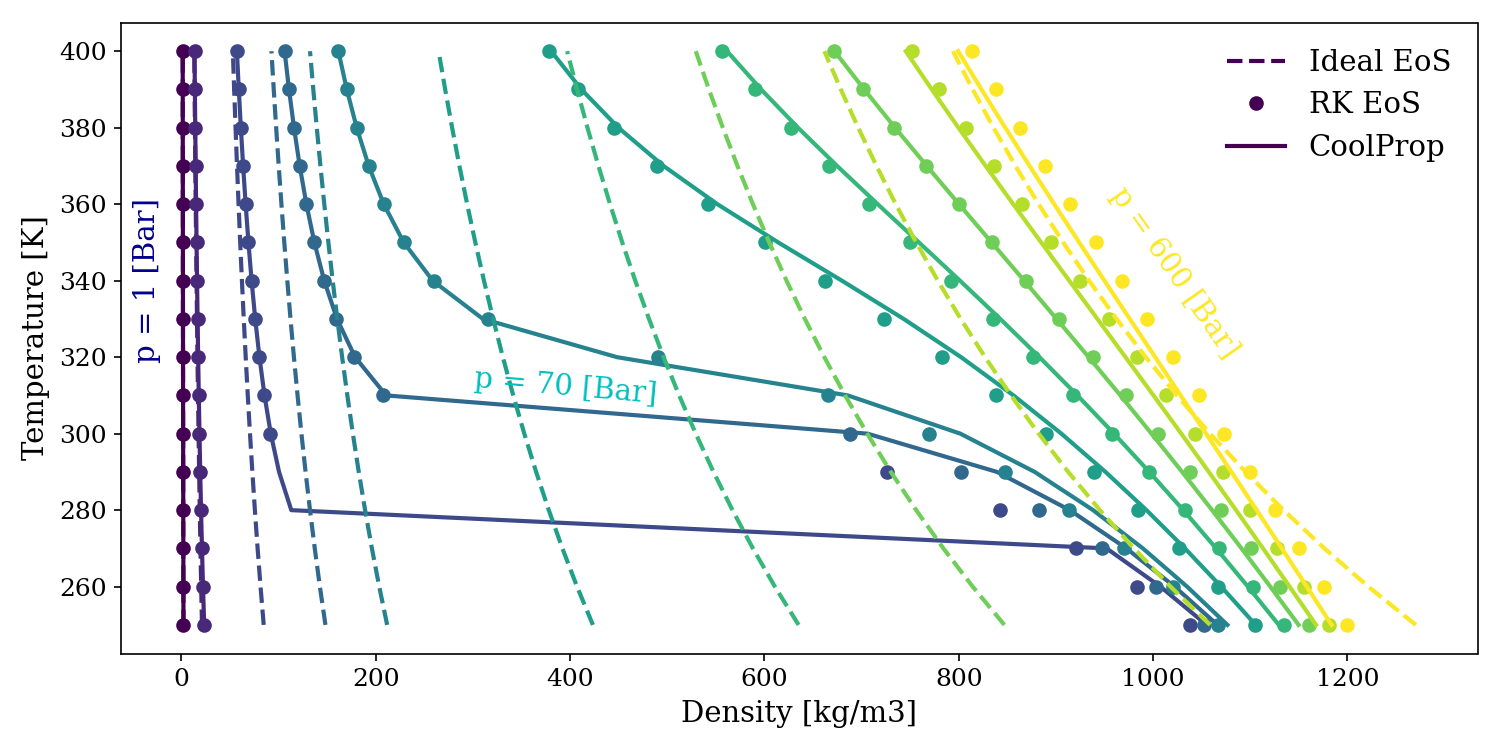

In [6]:
# Input parameters
# Set up arrays for pressure and temperature
p_array = [1] + [i for i in np.arange(10,101,30)] + [i for i in np.arange(200,601,100)]     # Pressure is varied from 1 to 600 bar
T_array = [i for i in np.arange(250,401,10)]     # Temperature is varied from 250K to 400K   

# Read ideal and non-ideal phases
gasIdeal = ct.Solution('data/co2-thermo.yaml', 'CO2-Ideal', transport=None)       # ideal gas-phase
gasRK = ct.Solution('data/co2-thermo.yaml', 'CO2-RK', transport=None)             # R-K gas-phase

# Loop over temperature and pressure
density_Ideal = np.zeros((len(p_array), len(T_array)))
density_RK = np.zeros((len(p_array), len(T_array)))
density_coolprop = np.zeros((len(p_array), len(T_array)))
       
# Plot
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'

line_width = 2
    
plt.figure(figsize=(10,5))
cmap= plt.get_cmap()
colors = iter(cmap(np.linspace(0,1,len(p_array))))

for i in range(len(p_array)):
    p = 1e5* p_array[i]
    
    states = ct.SolutionArray(gasIdeal, len(T_array))
    states.TP = T_array, p
    density_Ideal = states.density_mass
    
    states = ct.SolutionArray(gasRK, len(T_array))
    states.TP = T_array, p
    density_RK = states.density_mass
    
    for j in range(len(T_array)):
        density_coolprop[i,j] = PropsSI('D','P', p,'T',T_array[j],'HEOS::CO2')
        
    colr = next(colors)
    pBar = p/1e5;
    plt.plot(density_Ideal, T_array,'--',color=colr, linewidth = line_width, label= pBar)
    plt.plot(density_RK, T_array,'o',color=colr, linewidth = line_width)
    plt.plot(density_coolprop[i,:], T_array,'-',color=colr, linewidth = line_width)
    
plt.text(-50, 320, 'p = 1 [Bar]', color='darkblue', rotation = 'vertical', size = '14') 
plt.text(300, 308, 'p = 70 [Bar]', color= 'c', size = '14', rotation = '-5') 
plt.text(950, 320, 'p = 600 [Bar]', color=colr, size = '14', rotation = '-55') 
plt.xlabel('Density [kg/m3]')
plt.ylabel('Temperature [K]')
plt.legend(['Ideal EoS','RK EoS', 'CoolProp'], prop={'size': 14}, frameon=False)

The figure compares $T-\rho$ plots for ideal, R-K, and Helmholtz EoS at different operating pressures. All three EoS yield the same plots at low pressures (0 Bar and 10 Bar). However, the Ideal gas EoS departs significantly at high pressures ($P > 10$ Bar), where non-ideal effects are prominent. The R-K EoS closely matches the Helmholtz EoS at supercritical pressures ($P \ge 70$ Bar). However, it does depart in the liquid-vapor region that exists at $P < P_{\rm {crit}}$ and low temperatures (~$T_{\rm {crit}}$).